In [1]:
import sys
sys.path.insert(0,'/Users/blanca/Documents/TESIS/software/Bbarolo')
from pyBBarolo import version
print (version)

1.3.3dev


In [2]:
#from pyBBarolo.bayesian import BayesianBBarolo

In [3]:
from dynesty import plotting as dyplot

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from pyBBarolo.BB_interface import libBB

In [5]:

from pyBBarolo.bayesian import BayesianBBarolo
import ctypes, time, copy
from pyBBarolo import Param, Rings, FitMod3D, reshapePointer, vprint, isIterable
import os
import gc

[Blancas-MacBook-Pro.local:12244] shmem: mmap: an error occurred while determining whether or not /var/folders/jn/tjkfv7yj6vx0n23cdyjdp_9w0000gn/T//ompi.Blancas-MacBook-Pro.501/jf.0/3471769600/sm_segment.Blancas-MacBook-Pro.501.ceef0000.0 could be created.


In [6]:
# Set a different temporary directory
#os.environ['TMPDIR'] = os.path.join(os.path.expanduser('~'), 'tmp')

# Create the temporary directory if it doesn't exist
#if not os.path.exists(os.environ['TMPDIR']):
#    os.makedirs(os.environ['TMPDIR'])

In [7]:
def my_norm(model,data):
    nrm = np.nansum(data)/np.nansum(model)
    return nrm*model

def res_Gaussian(data,model,noise,mask,multiplier=1):
    """
    Gaussian residuals with noise
    """

    data *= mask
    model = my_norm(model,data)
    res = np.nansum((data-model)**2)

    return multiplier*res/(noise*noise)

def res_abs(data,model,noise,mask,multiplier=1):
    """
    Use absolute difference
    """
    
    data *= mask
    model = my_norm(model,data)
    res = np.nansum(np.abs(data-model))

    return multiplier*res/noise

In [8]:
##HERE WE MODIFY THE MAIN Byesian Barolo  implementation
class BayesianBBaroloMod(BayesianBBarolo):

    def __init__(self,fitsname,**kwargs):
        """ Initialize the BayesianBBarolo class.
    
        Parameters
        ----------
        fitsname : str
            The name of the fits file with the datacube to fit.
        **kwargs : dict
            Any other parameter to be passed to the BBarolo's library.
        """

        super(BayesianBBaroloMod,self).__init__(fitsname,**kwargs)
        self.noise=None
        self.Npix=None

    
    def _log_likelihood(self,theta):
        """ Likelihood function for the fit """
        
        rings = self._update_rings(self._inri,theta)

        # Calculate likelihood 
        if self.noise is None: self.noise=np.nanstd(self.data[0,:,:])
        if self.Npix is None:  self.Npix=np.prod(self.data.shape)

        if self.useBBres:
            # Calculating residuals through BBarolo directly
            res = libBB.Galfit_calcresiduals(self._galfit,rings._rings)
        else: 
            # Calculating residuals manually            

            # Recompute the density profile along the current rings and update the rings
            if self.useNorm and self.update_prof:
                self._update_profile(rings)

            # Calculate the model and the boundaries
            mod, bhi, blo, galmod = self._calculate_model(rings)
            
            # Calculate the residuals
            mask = self.mask[:,blo[1]:bhi[1],blo[0]:bhi[0]]
            data = self.data[:,blo[1]:bhi[1],blo[0]:bhi[0]]
            res  = self._calculate_residuals(mod,data,mask)

            libBB.Galmod_delete(galmod)
            
        return -res

    #Uncomment
    #Gaussian 
    def _calculate_residuals(self,model,data,mask=None):
        
        #Option A: Standard absolute residuals: no noise, residual muplitied by 1000 as done before
        #res=res_abs(model=model, data=data, noise=1, mask=mask, multiplier=1000)

        #Option B Standard absolute residuals: cube noise, residual muplitied by 1000 as done before
        #res=res_abs(model=model, data=data, noise=self.noise, mask=mask, multiplier=1000)

        #Option C Standard Gaussian residuals: cube noise,
        res=res_Gaussian(model=model, data=data, noise=self.noise, mask=mask, multiplier=1)

        #Option D Gaussian residuals: no noise
        #res=res_Gaussian(model=model, data=data, noise=1, mask=mask, multiplier=1)

        #Option E Gaussian residuals: no noise, multiplied by 1000
        #res=res_Gaussian(model=model, data=data, noise=1, mask=mask, multiplier=1000)


        return res

In [9]:
# Name of the FITS file to be fitted
model = "model4_C_new_2"
fitsname = f"/Users/blanca/Documents/TESIS/software/THESIS/models/model4/model4.fits"
freepar = ['vrot','vdisp','inc_single','phi_single']
#Uncomment to fit the density
#freepar = ['vrot','vdisp','dens','inc_single','phi_single']
output = "/Users/blanca/Documents/TESIS/software/THESIS/tests_new_res"

In [10]:

# Creating an object for bayesian barolo
f3d = BayesianBBaroloMod(fitsname)

# Initializing rings. 
f3d.init(radii=np.arange(30,240,60),xpos=25.5,ypos=25.5,vsys=0.0,\
         vrot=100,vdisp=10,vrad=0,z0=30,inc=60,phi=0)

# Here it is possible to give any other BBarolo parameter, for example to control
# the mask, linear, bweight, cdens, wfunc, etc...
f3d.set_options(mask="SEARCH",linear=0,outfolder=f"{output}/{model}",plotmask=True, threads=8)
#To remove the mask
#f3d.set_options(mask="NONE",linear=0,outfolder=f"output/{model}",plotmask=True)

f3d.show_options()

# Default priors are uniform and the default boundaries for the fit are in f3d.bounds.
f3d.bounds['vrot']  = [0,250]
f3d.bounds['vdisp'] = [1,40]
f3d.bounds['inc']   = [20,80]
f3d.bounds['phi']   = [-20,20]
f3d.bounds['z0']    = [0,60]
f3d.bounds['xpos']  = [20,30]
f3d.bounds['ypos']  = [20,30]
f3d.bounds['vsys']  = [-20,20]
f3d.bounds['dens']  = [1,30]


# Keywords to be passed to the sample run
run_kwargs = dict()
# Keywords to be passed to the 
sample_kwargs = dict()

# Running the fit with dynesty.
f3d.compute(threads=8,useBBres=False,method='dynesty',dynamic=True,
            freepar=freepar,run_kwargs=run_kwargs,sample_kwargs=sample_kwargs)


HEADER WARNING: TELESCOP-INSTRUME keywords not found.

Opening file /Users/blanca/Documents/TESIS/software/THESIS/models/model4/model4.fits
Reading 51 x 51 x 64 pixels FITS file (0.6 MB)... Done. 

##### Input parameters for BBarolo #####
FITSFILE           /Users/blanca/Documents/TESIS/software/THESIS/models/model4/model4.fits 
THREADS            8 
OUTFOLDER          /Users/blanca/Documents/TESIS/software/THESIS/tests_new_res/model4_C_new_2 
TWOSTAGE           False 
MASK               SEARCH 
LINEAR             0 
PLOTMASK           True 



6145it [00:33, 181.11it/s, batch: 0 | bound: 0 | nc: 8 | ncall: 27289 | eff(%): 22.113 | loglstar:   -inf < -144.278 <    inf | logz: -155.837 +/-  0.151 | dlogz:  0.481 >  0.010]Killed by the user.
Killed by the user.
Killed by the user.
Killed by the user.
Killed by the user.
Killed by the user.
Killed by the user.
Killed by the user.



KeyboardInterrupt: 

In [ ]:
print (f3d.params,f3d._log_likelihood(f3d.params))

# Writing best model and plots (experimental, to be checked)
f3d.write_bestmodel()

# Print some statistics of the sample
f3d.print_stats()


[ 1.26804652e+02  1.29143918e+02  1.28195532e+02  1.25098296e+02
  2.01648745e+01  2.09899415e+01  2.03635606e+01  2.04007337e+01
  5.06195810e+01 -5.59722760e-02] -118128.62345764073

Writing the best model to output directory ... Done!

Best-fit parameters:
       vrot1 =    126.987    -86.122    +84.398
       vrot2 =    129.516    -87.846    +82.345
       vrot3 =    128.054    -86.675    +85.028
       vrot4 =    125.343    -85.912    +85.425
      vdisp1 =     20.053    -13.120    +13.453
      vdisp2 =     20.966    -13.617    +13.030
      vdisp3 =     20.354    -13.002    +13.350
      vdisp4 =     20.414    -13.174    +13.303
         inc =     50.620    -20.285    +20.152
         phi =     -0.013    -13.603    +13.634

Maximum logl: -144.0298810182254 at:
       vrot1 =     11.346 
       vrot2 =    166.825 
       vrot3 =     33.921 
       vrot4 =    212.297 
      vdisp1 =      9.458 
      vdisp2 =      3.971 
      vdisp3 =     12.195 
      vdisp4 =     23.591 
      

(         niter: 16159
          ncall: array([1, 1, 1, ..., 1, 1, 1])
            eff: 7.8405209222886425
        samples: array([[129.55891091,  20.38015877,   7.69474941, ...,   1.25581419,
          34.94689376,  14.13020988],
        [125.21730536, 118.53241385,  40.78697112, ...,   6.98403573,
          47.96819737,   9.75320264],
        [200.56414298, 127.76623194,   4.46329904, ...,  29.84769364,
          25.78582195,  -9.30860132],
        ...,
        [138.74758946,  81.3867089 , 236.06890572, ...,  17.54235923,
          77.57433524, -13.63083275],
        [100.48283386, 108.82069351, 218.94053942, ...,  20.11974769,
          65.44439346,  -1.78521263],
        [115.73534161,  88.38116758, 210.550731  , ...,  39.60916152,
          70.60575823,  -7.38516115]])
     samples_id: array([   4,   25,   70, ..., 3437,  166, 1904])
  samples_batch: array([0, 0, 0, ..., 6, 0, 3])
     samples_it: array([    0,     0,     0, ..., 10610,  5983,  9031])
      samples_u: array([[0.51

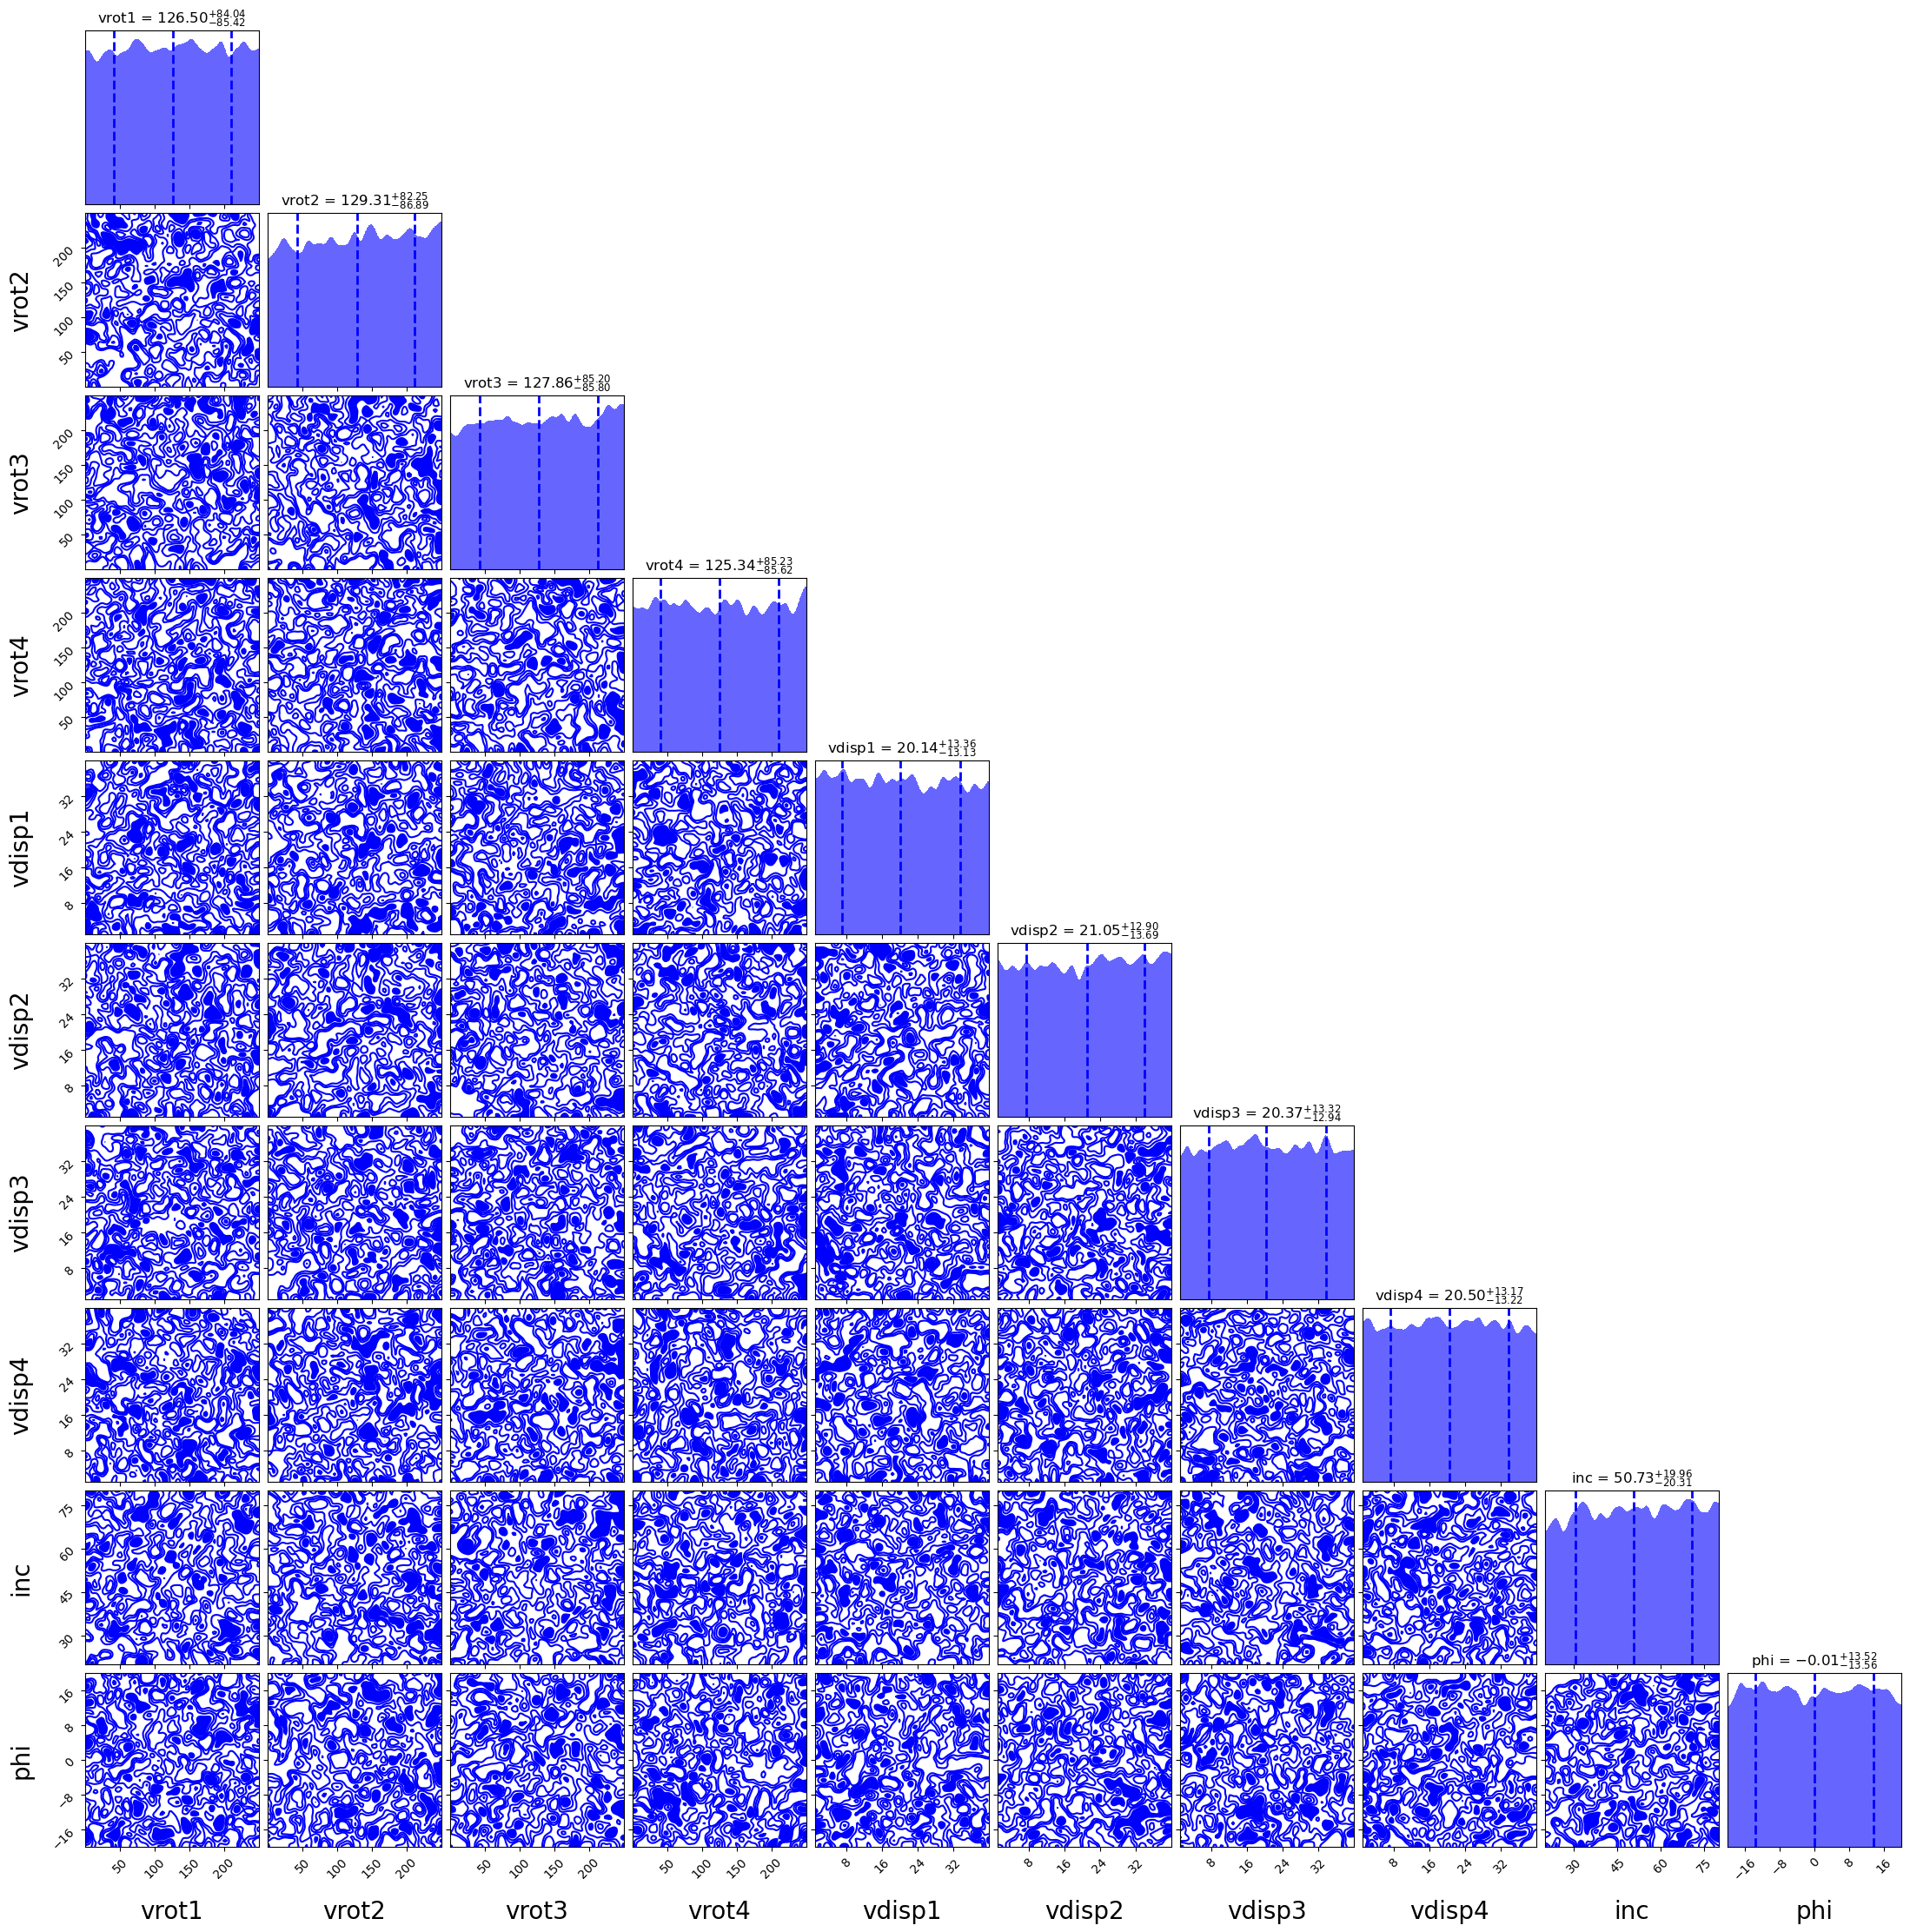

In [ ]:
# Plot the 2-D marginalized posteriors.
quantiles = [0.16,0.50,0.84]
cfig, caxes = dyplot.cornerplot(f3d.results,show_titles=True,title_quantiles=quantiles,
                                quantiles=quantiles, color='blue',max_n_ticks=5, \
                                labels=f3d.freepar_names, label_kwargs=dict(fontsize=20))
cfig.savefig(f'{output}/{model}/{model}_corner.pdf',bbox_inches='tight')

# Saving samples
np.save("dynesty_samples.npy", f3d.results.samples)

In [ ]:
del f3d
gc.collect()

9244